In [1]:
from datasets import load_dataset

train_dataset = load_dataset("json", data_files="..\datasets\\midas-discourse\\hi\\train.json", \
                             split="train")

Using custom data configuration default-3a3d5814a8cfcd9e
Found cached dataset json (C:/Users/arifa/.cache/huggingface/datasets/json/default-3a3d5814a8cfcd9e/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51)


In [2]:
val_dataset = load_dataset("json", data_files="..\datasets\\midas-discourse\\hi\\val.json", \
                             split="train")

Using custom data configuration default-3541c228aae61542
Found cached dataset json (C:/Users/arifa/.cache/huggingface/datasets/json/default-3541c228aae61542/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51)


In [3]:
test_dataset = load_dataset("json", data_files="..\datasets\\midas-discourse\\hi\\test.json", \
                             split="train")

Using custom data configuration default-1b196b1d18f05fca
Found cached dataset json (C:/Users/arifa/.cache/huggingface/datasets/json/default-1b196b1d18f05fca/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51)


In [4]:
from datasets import Dataset, DatasetDict

datasets = DatasetDict()
datasets['train'] = train_dataset
datasets['validation'] = val_dataset
datasets['test'] = test_dataset

In [5]:
datasets

DatasetDict({
    train: Dataset({
        features: ['Story_no', 'Sentence', 'Discourse Mode', 'id'],
        num_rows: 7974
    })
    validation: Dataset({
        features: ['Story_no', 'Sentence', 'Discourse Mode', 'id'],
        num_rows: 997
    })
    test: Dataset({
        features: ['Story_no', 'Sentence', 'Discourse Mode', 'id'],
        num_rows: 997
    })
})

In [6]:
datasets["train"][:5]

{'Story_no': [24, 19, 1, 47, 47],
 'Sentence': ['पाँच साल गुजर गये।',
  " बिरजू के माँ ने आँगन से निकल गाँव की ओर कान लगा कर सुनने की चेष्टा की-' उँहुँ, इतनी देर तक भला पैदल जानेवाले रुके रहेंगे?' पूर्णिमा का चाँद सिर पर आ गया है।",
  ' कुछ लोग घर वाले होते हैं, कुछ लोग सीढ़ीयों के पीछे सोने वाले होते हैं, कुछ लोग गालियां देते हैं, कुछ लोग गालियां सहते हैं।',
  'राम खिलावन ने अपनी कोठरी में जाकर अन्दर से दरवाज़ा लगा लिया और लाठी को चूल्हे में जला दी।',
  " इन्होंने कहा' शहर कोतवाल का अधिकार पूर्ण शब्द उनके कानों में गूंज गया।"],
 'Discourse Mode': ['Narrative',
  'Narrative',
  'Descriptive',
  'Narrative',
  'Dialogue'],
 'id': ['4669', '3296', '237', '9030', '9082']}

In [7]:
datasets.set_format("pandas")

In [8]:
# get label counts for both classes
label_counts = datasets["train"]["Discourse Mode"].value_counts()
num_labels = (len(label_counts.keys()))

In [9]:
label_counts

Descriptive      2912
Narrative        2489
Dialogue         2361
Argumentative     105
Informative        67
Other              40
Name: Discourse Mode, dtype: int64

In [10]:
datasets.reset_format()

In [11]:
from transformers import PreTrainedTokenizerFast, AutoModelForSequenceClassification, AutoTokenizer

tokenizer = PreTrainedTokenizerFast.from_pretrained("../Hindi Pretraining/models/unigram/bert-base-pretrained-hindi")

In [12]:
def tokenize_function(example):
    #return tokenizer(example['Sentence'], truncation=True)
    return tokenizer(example["Sentence"], truncation=True, max_length=128)

In [13]:
datasets

DatasetDict({
    train: Dataset({
        features: ['Story_no', 'Sentence', 'Discourse Mode', 'id'],
        num_rows: 7974
    })
    validation: Dataset({
        features: ['Story_no', 'Sentence', 'Discourse Mode', 'id'],
        num_rows: 997
    })
    test: Dataset({
        features: ['Story_no', 'Sentence', 'Discourse Mode', 'id'],
        num_rows: 997
    })
})

In [14]:
from transformers import DataCollatorWithPadding

tokenized_datasets = datasets.map(tokenize_function, batched=True, remove_columns=['Story_no', 'Sentence', 'id'])
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Loading cached processed dataset at C:\Users\arifa\.cache\huggingface\datasets\json\default-3a3d5814a8cfcd9e\0.0.0\0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51\cache-1da3b2109297219a.arrow
Loading cached processed dataset at C:\Users\arifa\.cache\huggingface\datasets\json\default-3541c228aae61542\0.0.0\0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51\cache-d2a0445ddd203610.arrow
Loading cached processed dataset at C:\Users\arifa\.cache\huggingface\datasets\json\default-1b196b1d18f05fca\0.0.0\0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51\cache-c02832e51825428c.arrow


In [15]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['Discourse Mode', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 7974
    })
    validation: Dataset({
        features: ['Discourse Mode', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 997
    })
    test: Dataset({
        features: ['Discourse Mode', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 997
    })
})

In [16]:
def assign_label(example):
    mapping = {
    "Descriptive":0,
    "Narrative":1,
    "Dialogue":2,
    "Argumentative":3,
    "Informative":4,
    "Other":5
    }
    example['labels'] = mapping[example['Discourse Mode']]
    return example

In [17]:
tokenized_datasets = tokenized_datasets.map(assign_label).remove_columns('Discourse Mode')
tokenized_datasets.set_format("torch")
tokenized_datasets.column_names

Loading cached processed dataset at C:\Users\arifa\.cache\huggingface\datasets\json\default-3a3d5814a8cfcd9e\0.0.0\0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51\cache-ebce8a6d8387e6fd.arrow
Loading cached processed dataset at C:\Users\arifa\.cache\huggingface\datasets\json\default-3541c228aae61542\0.0.0\0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51\cache-12aee0f226282a86.arrow
Loading cached processed dataset at C:\Users\arifa\.cache\huggingface\datasets\json\default-1b196b1d18f05fca\0.0.0\0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51\cache-a63666a64de42380.arrow


{'train': ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
 'validation': ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
 'test': ['input_ids', 'token_type_ids', 'attention_mask', 'labels']}

In [18]:
samples = [tokenized_datasets["train"][i] for i in range(5)]
samples

for chunk in data_collator(samples)["input_ids"]:
    print(f"\n'>>> {tokenizer.decode(chunk)}'")

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



'>>> [CLS] पाँच साल गुजर गये।[SEP][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]'

'>>> [CLS] बिरजू के माँ ने आँगन से निकल गाँव की ओर कान लगा कर सुनने की चेष्टा की-[UNK] उँहुँ, इतनी देर तक भला पैदल जानेवाले रुके रहेंगे?[UNK] पूर्णिमा का चाँद सिर पर आ गया है।[SEP]'

'>>> [CLS] कुछ लोग घर वाले होते हैं, कुछ लोग सीढ़ीयों के पीछे सोने वाले होते हैं, कुछ लोग गालियां देते हैं, कुछ लोग गालियां सहते हैं।[SEP][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]'

'>>> [CLS] राम खिलावन ने अपनी कोठरी में जाकर अन्दर से दरवाज़ा लगा लिया और लाठी को चूल्हे में जला दी।[SEP][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]'

'>>> [CLS] इन्होंने कहा[UNK] शहर कोतवाल का अधिकार पूर्ण शब्द उनके कानों में गूंज गया।[SEP][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]

In [19]:
datasets["train"][:5]

{'Story_no': [24, 19, 1, 47, 47],
 'Sentence': ['पाँच साल गुजर गये।',
  " बिरजू के माँ ने आँगन से निकल गाँव की ओर कान लगा कर सुनने की चेष्टा की-' उँहुँ, इतनी देर तक भला पैदल जानेवाले रुके रहेंगे?' पूर्णिमा का चाँद सिर पर आ गया है।",
  ' कुछ लोग घर वाले होते हैं, कुछ लोग सीढ़ीयों के पीछे सोने वाले होते हैं, कुछ लोग गालियां देते हैं, कुछ लोग गालियां सहते हैं।',
  'राम खिलावन ने अपनी कोठरी में जाकर अन्दर से दरवाज़ा लगा लिया और लाठी को चूल्हे में जला दी।',
  " इन्होंने कहा' शहर कोतवाल का अधिकार पूर्ण शब्द उनके कानों में गूंज गया।"],
 'Discourse Mode': ['Narrative',
  'Narrative',
  'Descriptive',
  'Narrative',
  'Dialogue'],
 'id': ['4669', '3296', '237', '9030', '9082']}

In [20]:
from transformers import set_seed

set_seed(30)

In [21]:
model =  AutoModelForSequenceClassification.from_pretrained("../Hindi Pretraining/models/unigram/bert-base-pretrained-hindi", num_labels=num_labels)

Some weights of the model checkpoint at ../Hindi Pretraining/models/unigram/bert-base-pretrained-hindi were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the mo

In [22]:
import numpy as np
import evaluate

metric_fun = evaluate.load("accuracy")

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    metric_result = metric_fun.compute(references=labels, predictions=predictions)
    return {
        "accuracy": metric_result["accuracy"],
    }

In [23]:
#  disable weights and biases logging
import os
os.environ["WANDB_DISABLED"] = "true"

In [24]:
from transformers import TrainingArguments

# batch_size = 16
batch_size = 32
# Show the training loss with every epoch
logging_steps = len(tokenized_datasets["train"]) // batch_size


training_args = TrainingArguments(
    report_to = None,
    output_dir="models/bert-unigram-hindi-classifier",
    overwrite_output_dir=True,
    save_strategy="epoch",
    evaluation_strategy="epoch",
    #learning_rate=2e-5,
    learning_rate=3e-5,
    weight_decay=0.01,
    #weight_decay=0.02,
    warmup_ratio = 0.1,
    #warmup_ratio = 0.05,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    #num_train_epochs=4,
    num_train_epochs=3,
    #push_to_hub=True,
    fp16=True,
    logging_steps=logging_steps,
    metric_for_best_model = 'accuracy',
    load_best_model_at_end=True,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [25]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    #train_dataset=entire_train,
    eval_dataset=tokenized_datasets["validation"],
    #eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [26]:
trainer.evaluate()

{'eval_loss': 1.8767454624176025,
 'eval_accuracy': 0.04714142427281846,
 'eval_runtime': 3.2627,
 'eval_samples_per_second': 305.573,
 'eval_steps_per_second': 9.808}

In [27]:
trainer.train()

C:\Users\arifa\anaconda3\envs\pytorch_env\lib\site-packages\transformers\optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.778300,0.598496,0.787362
2,0.459900,0.576113,0.789368
3,0.279200,0.634906,0.794383


TrainOutput(global_step=750, training_loss=0.5046688222090403, metrics={'train_runtime': 121.6519, 'train_samples_per_second': 196.643, 'train_steps_per_second': 6.165, 'total_flos': 881933680545624.0, 'train_loss': 0.5046688222090403, 'epoch': 3.0})

In [28]:
trainer.evaluate(tokenized_datasets["test"])

{'eval_loss': 0.5997897386550903,
 'eval_accuracy': 0.8144433299899699,
 'eval_runtime': 1.5958,
 'eval_samples_per_second': 624.759,
 'eval_steps_per_second': 20.052,
 'epoch': 3.0}

In [29]:
trainer.save_model()

In [30]:
y_preds, y_true, _ = trainer.predict(tokenized_datasets["test"])

In [31]:
y_preds = np.argmax(y_preds, axis=-1)

In [33]:
from sklearn.metrics import classification_report
target_names = ["Descriptive",
    "Narrative",
    "Dialogue",
    "Argumentative",
    "Informative",
    "Other"]
print(classification_report(y_true, y_preds,target_names=target_names))

               precision    recall  f1-score   support

  Descriptive       0.83      0.82      0.82       380
    Narrative       0.80      0.82      0.81       316
     Dialogue       0.82      0.85      0.83       272
Argumentative       0.50      0.23      0.32        13
  Informative       0.67      0.20      0.31        10
        Other       1.00      1.00      1.00         6

     accuracy                           0.81       997
    macro avg       0.77      0.65      0.68       997
 weighted avg       0.81      0.81      0.81       997



Text(0.5, 1.0, 'Confusion matrix for DA')

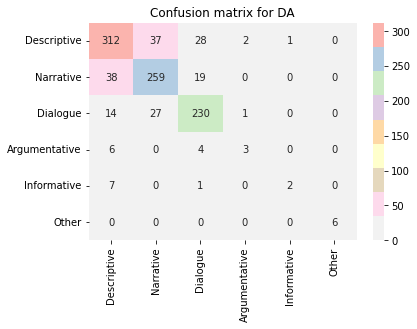

In [34]:
import matplotlib.pyplot as plt
from seaborn import heatmap
from sklearn.metrics import confusion_matrix

#plot heatmap of confusion matrix
mat = confusion_matrix(y_true, y_preds)
heatmap(mat, cmap="Pastel1_r", fmt="d", xticklabels=target_names, yticklabels=target_names, annot=True)

#add overall title to plot
plt.title('Confusion matrix for DA', fontsize = 12) # title with fontsize 20

In [35]:
misclassified = [i for i in range(len(y_preds)) if ((y_preds[i] != y_true[i]) and (y_true[i]==4) and (y_preds[i]==0))]

In [38]:
misclassified

[382, 412, 553, 628, 662, 695, 721]

In [39]:
misclassified_dataset = test_dataset.select(misclassified)

In [40]:
misclassified_dataset[:]

{'Story_no': [32, 35, 40, 47, 51, 34, 25],
 'Sentence': ['ऐसे आवास में विद्या नहीं आती।',
  'वो सारा दिन एक तकरार के साथ दिमाग़ में चक्कर लगाता रहता है और बाज़ वक़्त तो इन्सान उस के मअनी को भी नहीं समझता। पर गुनगुनाता चला जाता है।',
  'सर्दी से निकल अगर आदमी गर्मी में जाये तो उसे हर लिहाज़ से राहत मिलती है और फ़र्ख़ंदा को ये हासिल होती थी।',
  ' चौबीसों घंटे गुलामी बजानी पड़ती है, तब कहीं तीन सौ रुपल्ली मिलते हैं।',
  ' जवानी जीवनभर का शुभ मुहूर्त है, सबसे पुष्\u200dट, कर्मठ और तेजस्\u200dवी सम्\u200dमान्\u200dय, फलत: क्रियाएं भी सबसे अधिक महत्\u200dवपूर्ण, धार्मिकता लिए हुए।',
  ' सर-ए-शाम चांद, गरहन के ज़म्रे में दाख़िल हो जाता है।',
  ' स्त्री गालियॉँ सह लेती हैं, मार भी सह लेती हैं; पर मैके की निंदा उनसे नहीं सही जाती।'],
 'Discourse Mode': ['Informative',
  'Informative',
  'Informative',
  'Informative',
  'Informative',
  'Informative',
  'Informative'],
 'id': ['6666', '7161', '8218', '9090', '9689', '6882', '5253']}